# Rede CNN - Modelo 2

## Dataset Respiratory_Sound_Database_Pneumo_Healthy_Only - slide10

In [1]:
from datetime import datetime
from os import listdir
from os.path import isfile, join

import os
import librosa
import librosa.display
import glob

import numpy as np
import pandas as pd

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv2D, MaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint

from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Necessário na minha máquina. Estava ocorrendo um erro devido à GPU e esse código resolveu.
import tensorflow as tf
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Currently, memory growth needs to be the same across GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        # Memory growth must be set before GPUs have been initialized
        print(e)

1 Physical GPUs, 1 Logical GPUs


In [3]:
GROUP = 'slide10'
MAX_PAD_LEN = 431

In [4]:
filepaths = glob.glob(f'./datasets/{GROUP}/**/*.wav', recursive=True)
filenames = [os.path.splitext(os.path.basename(p))[0] for p in filepaths]

In [5]:
p_id_in_file = [] # patient IDs corresponding to each file
for name in filenames:
    p_id_in_file.append(int(name[:3]))

p_id_in_file = np.array(p_id_in_file) 

In [6]:
max_pad_len =  MAX_PAD_LEN

os.makedirs("./Respiratory_Sound_Database/features/", exist_ok=True)

def extract_features(file_name):
    """
    This function takes in the path for an audio file as a string, loads it, and returns the MFCC
    of the audio"""
    feature = os.path.splitext(os.path.basename(file_name))[0] + ".npy"
#     if (os.path.isfile(os.path.join("./Respiratory_Sound_Database/features/", feature))):
#         return np.load(os.path.join("./Respiratory_Sound_Database/features/", feature))
    
    try:
        audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast', duration=10) 
        mfccs = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
        pad_width = max_pad_len - mfccs.shape[1]
        mfccs = np.pad(mfccs, pad_width=((0, 0), (0, pad_width)), mode='constant')
        
    except Exception as e:
        print("Error encountered while parsing file: ", file_name)
        return None 
    np.save(os.path.join("./Respiratory_Sound_Database/features/", feature), mfccs)
    return mfccs

In [7]:
#filepaths = [join(mypath, f) for f in filenames] # full paths of files

In [8]:
p_diag = pd.read_csv("./Respiratory_Sound_Database/Respiratory_Sound_Database/patient_diagnosis.csv",header=None) # patient diagnosis file

In [9]:
labels = np.array([p_diag[p_diag[0] == x][1].values[0] for x in p_id_in_file]) # labels for audio files

In [10]:
features = [] 

# Iterate through each sound file and extract the features
for file_name in filepaths:
    data = extract_features(file_name)
    features.append(data)

print('Finished feature extraction from ', len(features), ' files')
features = np.array(features)

Finished feature extraction from  576  files


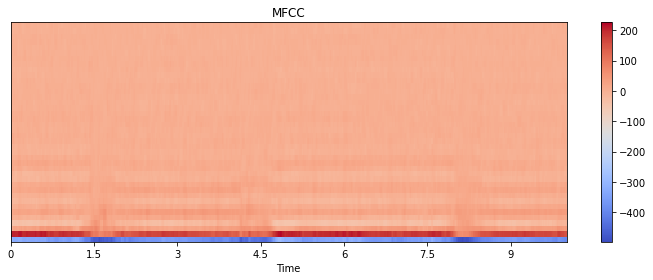

In [11]:
# plot an MFCC
plt.figure(figsize=(10, 4))
librosa.display.specshow(features[1], x_axis='time')
plt.colorbar()
plt.title('MFCC')
plt.tight_layout()
plt.show()

In [12]:
features = np.array(features) # convert to numpy array

In [13]:
np.unique(labels)

array(['Healthy', 'Pneumonia'], dtype='<U9')

In [14]:
# delete diseases
'''
features1 = features
labels1 = labels'''

features1 = np.delete(features, np.where((labels == 'Asthma') | (labels == 'LRTI') | (labels == 'Bronchiectasis') | (labels == 'Bronchiolitis') | (labels == 'COPD') | (labels == "URTI"))[0], axis=0) 

labels1 = np.delete(labels, np.where((labels == 'Asthma') | (labels == 'LRTI') | (labels == 'Bronchiectasis') | (labels == 'Bronchiolitis') | (labels == 'COPD') | (labels == "URTI"))[0], axis=0) 



In [15]:
# print class counts
unique_elements, counts_elements = np.unique(labels1, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

[['Healthy' 'Pneumonia']
 ['280' '296']]


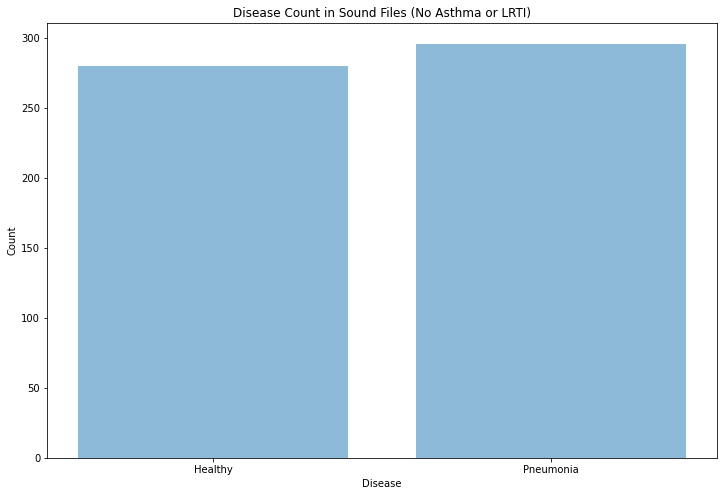

In [16]:
# plot class counts
y_pos = np.arange(len(unique_elements))
plt.figure(figsize=(12,8))
plt.bar(unique_elements, counts_elements, align='center', alpha=0.5)
plt.xticks(y_pos, unique_elements)
plt.ylabel('Count')
plt.xlabel('Disease')
plt.title('Disease Count in Sound Files (No Asthma or LRTI)')
plt.show()

In [17]:
# One-hot encode labels
le = LabelEncoder()
i_labels = le.fit_transform(labels1)
oh_labels = to_categorical(i_labels) 

In [18]:
features1.shape

(576, 40, 431)

In [19]:
# add channel dimension for CNN
features1 = np.reshape(features1, (*features1.shape,1)) 

# train test split
x_train, x_test, y_train, y_test = train_test_split(features1, oh_labels, stratify=oh_labels, 
                                                    test_size=0.2, random_state = 42)

**MLP model architecture**

In [20]:
num_rows = 40
num_columns = 431
num_channels = 1

num_labels = oh_labels.shape[1]
filter_size = 2

# Construct model 
model = Sequential()
model.add(Conv2D(filters=32, kernel_size=filter_size,
                 input_shape=(num_rows, num_columns, num_channels), activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=16, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=8, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(Conv2D(filters=4, kernel_size=filter_size, activation='relu'))
model.add(MaxPooling2D(pool_size=2))
model.add(Dropout(0.2))

model.add(GlobalAveragePooling2D())

model.add(Dense(num_labels, activation='softmax')) 

In [21]:
# Compile the model
model.compile(loss='categorical_crossentropy', metrics=['accuracy'], optimizer='adam') 

In [22]:
# Display model architecture summary 
model.summary()

# Calculate pre-training accuracy 
score = model.evaluate(x_test, y_test, verbose=1)
accuracy = 100*score[1]

print("Pre-training accuracy: %.4f%%" % accuracy)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 39, 430, 32)       160       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 19, 215, 32)       0         
_________________________________________________________________
dropout (Dropout)            (None, 19, 215, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 18, 214, 16)       2064      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 9, 107, 16)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 9, 107, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 106, 8)         5

**Training**

Here we will train the model. If we have a trained model, we can load it instead from the next cell.

In [23]:
# train model
num_epochs = 250
num_batch_size = 10

os.makedirs('models', exist_ok=True)
callbacks = [
    ModelCheckpoint(
        filepath='models/model2_{epoch:02d}.h5',
        # Path where to save the model
        # The two parameters below mean that we will overwrite
        # the current checkpoint if and only if
        # the `val_accuracy` score has improved.
        save_best_only=True,
        monitor='val_accuracy',
        verbose=1)
]
start = datetime.now()

history = model.fit(x_train, y_train, batch_size=num_batch_size, epochs=num_epochs,
                    validation_data=(x_test, y_test), callbacks=callbacks, verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Train on 460 samples, validate on 116 samples
Epoch 1/250
430/460 [===========================>..] - ETA: 0s - loss: 1.2525 - accuracy: 0.5326
Epoch 00001: val_accuracy improved from -inf to 0.48276, saving model to models/model2_01.h5
460/460 [==============================] - 1s 2ms/sample - loss: 1.2300 - accuracy: 0.5435 - val_loss: 1.1753 - val_accuracy: 0.4828
Epoch 2/250
420/460 [==========================>...] - ETA: 0s - loss: 0.8082 - accuracy: 0.5857
Epoch 00002: val_accuracy improved from 0.48276 to 0.52586, saving model to models/model2_02.h5
460/460 [==============================] - 1s 1ms/sample - loss: 0.7935 - accuracy: 0.5935 - val_loss: 0.6345 - val_accuracy: 0.5259
Epoch 3/250
420/460 [==========================>...] - ETA: 0s - loss: 0.6843 - accuracy: 0.6143
Epoch 00003: val_accuracy improved from 0.52586 to 0.71552, saving model to models/model2_03.h5
460/460 [==============================] - 1s 1ms/sample - loss: 0.6890 - accuracy: 0.6065 - val_loss: 0.5710 - 

**Plot accuracies and losses**

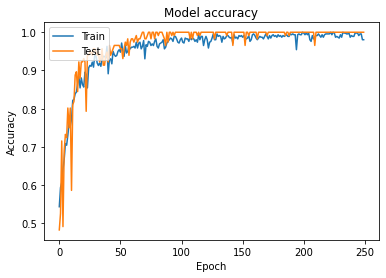

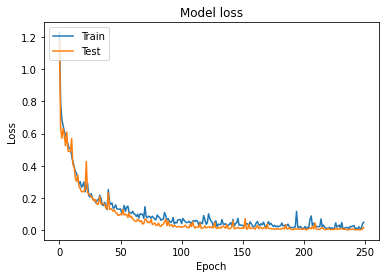

In [24]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

## Teste

Lembrando que estamos utilizando o mesmo conjunto de validacão, que a princípio, pode incluir instâncias do conjunto de treinamento: o dataset utilizado foi gerado com corte de áudio, então alguns trechos do mesmo áudio podem estar presentes em ambos os conjuntos de treinamento e teste.
Por ora deixamos assim já que estamos realizando uma investigacão inicial.

In [25]:
# Evaluating the model on the training and testing set
score = model.evaluate(x_train, y_train, verbose=0)
print("Training Accuracy: ", score[1])

score = model.evaluate(x_test, y_test, verbose=0)
print("Testing Accuracy: ", score[1])

Training Accuracy:  0.99130434
Testing Accuracy:  1.0


In [26]:
preds = model.predict(x_test) # label scores 

classpreds = np.argmax(preds, axis=1) # predicted classes 

y_testclass = np.argmax(y_test, axis=1) # true classes

n_classes=2 # number of classes

In [27]:
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], preds[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

In [28]:
c_names = ['Bronchiectasis', 'Bronchiolitis', 'COPD', 'Healthy', 'Pneumonia', 'URTI']
c_names = ['Healthy', 'Pneumonia']

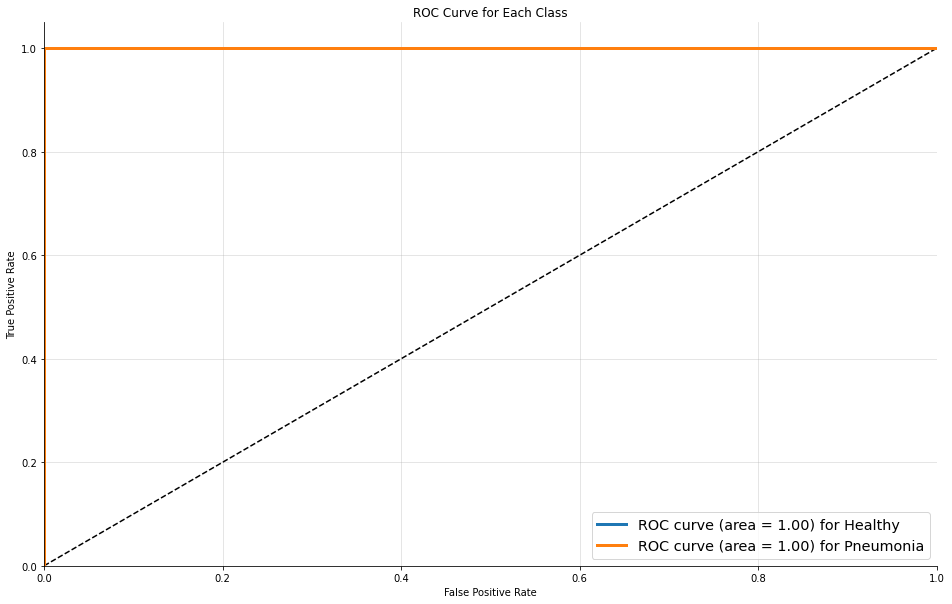

In [29]:
# Plot ROC curves
fig, ax = plt.subplots(figsize=(16, 10))
ax.plot([0, 1], [0, 1], 'k--')
ax.set_xlim([0.0, 1.0])
ax.set_ylim([0.0, 1.05])
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve for Each Class')
for i in range(n_classes):
    ax.plot(fpr[i], tpr[i], linewidth=3, label='ROC curve (area = %0.2f) for %s' % (roc_auc[i], c_names[i]))
ax.legend(loc="best", fontsize='x-large')
ax.grid(alpha=.4)
sns.despine()
plt.show()

In [30]:
# Classification Report
print(classification_report(y_testclass, classpreds, target_names=c_names))

              precision    recall  f1-score   support

     Healthy       1.00      1.00      1.00        56
   Pneumonia       1.00      1.00      1.00        60

    accuracy                           1.00       116
   macro avg       1.00      1.00      1.00       116
weighted avg       1.00      1.00      1.00       116



In [31]:
# Confusion Matrix
print(confusion_matrix(y_testclass, classpreds))

[[56  0]
 [ 0 60]]


In [32]:
import itertools
def plot_confusion_matrix(cm, unique_labels, show=True, output=None,
                          title='Confusion matrix', cmap=plt.cm.Oranges):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(cm.shape[1])
    plt.xticks(tick_marks, rotation=45)
    ax = plt.gca()
    ax.set_xticklabels((ax.get_xticks() + 1).astype(str))
    plt.yticks(tick_marks)

    ax.set_xticklabels(unique_labels)
    ax.set_yticklabels(unique_labels)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], '.1f'),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    if show:
        plt.show()
    if output is not None:
        plt.savefig(output)
    plt.close()
    return output


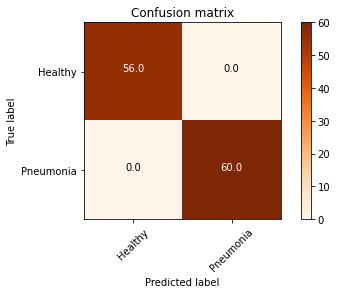

In [33]:
plot_confusion_matrix(confusion_matrix(y_testclass, classpreds), unique_labels=["Healthy", "Pneumonia"])